In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt

In [3]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:

#Train and test data
mnist_train=torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                       ]))


mnist_= torchvision.datasets.MNIST('mnist',
                          train=False,
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))
                          ])
                          )

In [5]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)
flatten = nn.Flatten()
#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(flatten(X).shape)
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
torch.Size([64, 784])


In [6]:
def plot_figure(df, column_x, 
                column_y, xlabel, 
                ylabel, size, 
                filename, title):
    fontsize=12
    colors = ['blue', 'red', 'green', 'orange', 'olive', 
              'pink', 'lime', 'maroon']
    fig, ax = plt.subplots(figsize=size,
                           sharey=True, 
                           sharex=True
                          )
    color_index=0
    column = 0
    ax.plot(
        df[column_x], 
        df[column_y],
         # align='center', 
         # alpha=0.5,
         # label=legends[i],
         color=colors[0],
         # ax=ax,
         linewidth=2
        )

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.tick_params(labelbottom=True)

    ax.legend(loc="upper right", frameon=True, 
              fontsize=fontsize)

    ax.set_title(title)

#         new_ax.tick_params(axis='x', labelrotation=90)
#     # plt.xticks(rotation = 90)
    
    fig.tight_layout(pad=4.0)

    fig.savefig(f'./{filename}', 
              facecolor='white', 
              transparent=False)

    plt.show()

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1024)
        self.l4 = nn.Linear(1024, 1024)
        self.l5 = nn.Linear(1024, 1024)
        self.l6 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.flatten(x)
        # print(x.shape)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = self.l6(x)
        
        return x


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.int).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    accuracy = round(100 * correct, 2)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred_y_all, org_y, input_x, accuracy

In [80]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    #predicted y, original y, input
    pred_y_all, org_y, input_x, accuracy = test(test_dataloader, 
                                                model, loss_fn)
    
print("Done!")

In [81]:
# torch.save(model.state_dict(), f'./hw_4_baseline.model')

torch.save(model, f'./hw_4_baseline.model')

### SVD compression

In [82]:
import copy

In [7]:
model = torch.load(f'./hw_4_baseline.model')

labels = ['u', 's', 'v']
parameters = model.state_dict()

with torch.no_grad():
    for key in parameters.keys():
        print(key)
        part = key.split('.')

        wt_part = part[-1]
        layer = part[0]

        print('----- layer ------ :', key)
        print(parameters[key].shape)

        if layer == 'l6':
            continue

        if wt_part == 'bias':
            continue

        u, s, v = torch.svd(parameters[key])
        s = torch.diag(s)

        print('\n ----- u, s, v ------- \n')
        print(u.shape, s.shape, v.shape)
        
        for i, x in enumerate([u, s, v]):
            label = labels[i]
            torch.save(x, f'{label}_{layer}.pt')

In [15]:
compression_dim = [10, 20, 50, 100, 200, 784]
labels = ['u', 's', 'v']
accuracy_data = []
loss_fn = nn.CrossEntropyLoss()

for dim in compression_dim:
    model = torch.load(f'./hw_4_baseline.model')
    with torch.no_grad():

        for key, layer in model.named_children():
            if key == 'flatten':
                continue

            if key == 'l6':
                continue

            u = torch.load(f'u_{key}.pt')
            s = torch.load(f's_{key}.pt')
            v = torch.load(f'v_{key}.pt')
            
            u_new = u[:, :dim]
            s_new = s[:dim, :dim]
            v_new = v[:, :dim]

            weights = u_new @ s_new @ v_new.T

            layer.weight.data = weights
    
    # print(u_new.shape, s_new.shape, v_new.T.shape)
    # print('----- layer ------ :', layer, dim)
    
    parameters = sum(p.numel() for p in model.parameters())
    
    pred_y_all, org_y, input_x, accuracy = test(test_dataloader,
                                  model, loss_fn)

    accuracy_data.append([dim, accuracy, parameters])

(pd.DataFrame(data=accuracy_data, 
              columns=['dimension', 'accuracy', 'num_of_parameters']
             )
 .to_pickle('svd_dim_accuracy.pkl.gz')
)
print("Done!")

Test Error: 
 Accuracy: 66.8%, Avg loss: 1.304089 

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.866055 

Test Error: 
 Accuracy: 86.8%, Avg loss: 0.485758 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.276635 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.139296 

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.095050 

Done!


In [8]:
df_accuracy = pd.read_pickle('svd_dim_accuracy.pkl.gz')

df_accuracy

,dimension,accuracy,num_of_parameters
0,10,66.83,5012490
1,20,76.87,5012490
2,50,86.75,5012490
3,100,92.13,5012490
4,200,96.01,5012490
5,784,97.44,5012490


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


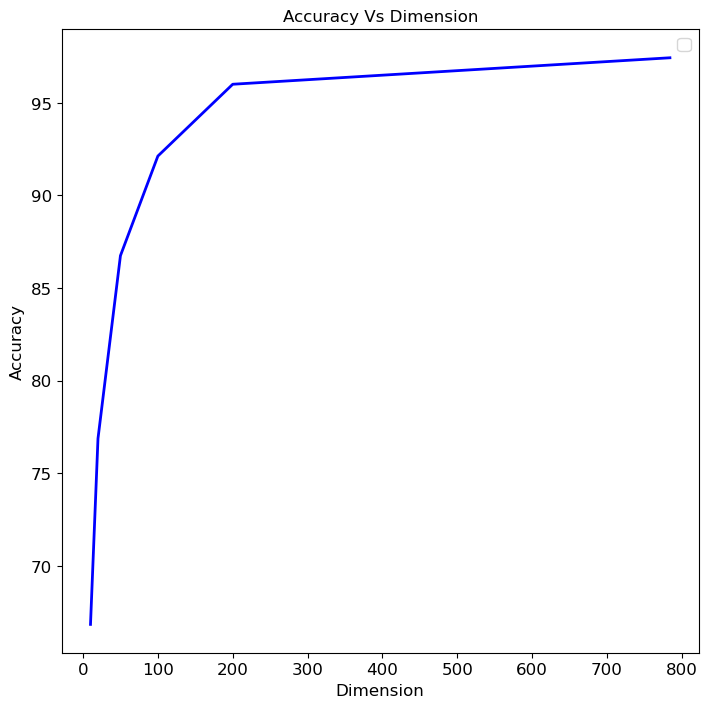

In [9]:
plot_figure(df_accuracy, 'dimension', 
            'accuracy', 'Dimension', 
            'Accuracy', (8,8), 
            'hw4_prblm_1_epoch_accuracy.png', 
            'Accuracy Vs Dimension')

### Problem 2

In [10]:
class NewNeuralNetwork(nn.Module):
    def __init__(self, dim=20):
        super(NewNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        self.l1_v = nn.Linear(784, dim, bias=False)
        self.l1_u = nn.Linear(dim, 1024, bias=True)
        
        self.l2_v = nn.Linear(1024, dim)
        self.l2_u = nn.Linear(dim, 1024)

        self.l3_v = nn.Linear(1024, dim)
        self.l3_u = nn.Linear(dim, 1024)

        self.l4_v = nn.Linear(1024, dim)
        self.l4_u = nn.Linear(dim, 1024)
        
        self.l5_v = nn.Linear(1024, dim)
        self.l5_u = nn.Linear(dim, 1024)

        self.l6 = nn.Linear(1024, 10)
        
        
        for key, layer in self.named_children():
            if key == 'flatten':
                continue
                
            parts = key.split('_')
            layer_name = parts[0]
            layer_last = parts[-1]
            
            if layer_name == 'l6':
                continue
                
            u = torch.load(f'u_{layer_name}.pt')
            s = torch.load(f's_{layer_name}.pt')
            v = torch.load(f'v_{layer_name}.pt')

            u_new = u[:, :dim]
            s_new = s[:dim, :dim]
            v_new = v[:, :dim]
            
            if layer_last == 'v':
                layer.weight.data = s_new @ v_new.T
                
            if layer_last == 'u':
                layer.weight.data = u_new
                

    def forward(self, x):
        x = self.flatten(x)
        # print(x.shape) #64 * 784
        
        x = F.relu(self.l1_u(self.l1_v(x)))
        x = F.relu(self.l2_u(self.l2_v(x)))
        x = F.relu(self.l3_u(self.l3_v(x)))
        x = F.relu(self.l4_u(self.l4_v(x)))
        x = F.relu(self.l5_u(self.l5_v(x)))
        
        x = self.l6(x)
        
        return x


def train_new(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_new(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.int).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    accuracy = round(100 * correct, 2)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred_y_all, org_y, input_x, accuracy


In [ ]:
model_self = NewNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_self.parameters(), lr=0.01)
epochs = 20
records = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_new(train_dataloader, model_self, loss_fn, optimizer)

    #predicted y, original y, input
    pred_y_all, org_y, input_x, accuracy = test_new(test_dataloader, 
                                                model_self, loss_fn)
    
    records.append([t, accuracy])
    
    
(pd.DataFrame(data=records, 
              columns=['epochs', 'accuracy']
             )
 .to_pickle('hw4_prblm_2_epoch_accuracy.pkl.gz')
)
    
print("Done!")

In [11]:
df_qns2 = pd.read_pickle('hw4_prblm_2_epoch_accuracy.pkl.gz')

df_qns2.head()

# 'epochs', 'accuracy'

,epochs,accuracy
0,0,95.78
1,1,96.48
2,2,96.70
3,3,96.82
4,4,96.92


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


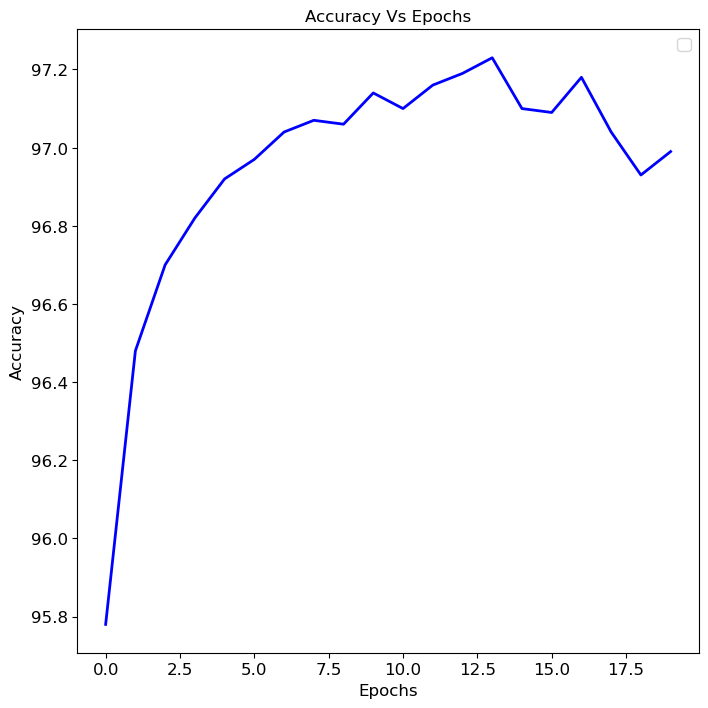

In [12]:
plot_figure(df_qns2, 'epochs', 
            'accuracy', 'Epochs', 
            'Accuracy', (8,8), 
            'hw4_prblm_2_epoch_accuracy.png', 
            'Accuracy Vs Epochs')

### Problem 3: Network Compression Using SVD

In [8]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)
flatten = nn.Flatten()
#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(flatten(X).shape)
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
torch.Size([64, 784])


In [21]:
class NeuralNetworkPb3(nn.Module):
    def __init__(self, parameters):
        super(NeuralNetworkPb3, self).__init__()
        
        self.customGrad = customGrad.apply
        self.flatten = nn.Flatten()
        
        self.l1 = nn.Linear(parameters['in_dim'], 
                            parameters['mid_dim'])
        self.l2 = nn.Linear(parameters['mid_dim'], 
                            parameters['mid_dim'])
        self.l3 = nn.Linear(parameters['mid_dim'], 
                            parameters['mid_dim'])
        self.l4 = nn.Linear(parameters['mid_dim'], 
                            parameters['mid_dim'])
        self.l5 = nn.Linear(parameters['mid_dim'], 
                            parameters['mid_dim'])
        self.l6 = nn.Linear(parameters['mid_dim'], 
                            parameters['out_dim'])
        
        model = torch.load(parameters['baseline_model'])

        weight_parameters = model.state_dict()

        for key, layer in self.named_children():
            
            if key == 'flatten':
                continue
                
            if key != 'l6':
                layer.bias.data = nn.Parameter(
                    torch.rand(parameters['mid_dim']))
            else:
                layer.bias.data = nn.Parameter(
                    torch.rand(parameters['out_dim']))
                
            layer.weight.data = weight_parameters[f'{key}.weight']
            
            
    def forward(self, x):
        x = self.flatten(x)

        for key, layer in self.named_children():
            if key == 'flatten':
                continue
            
            x = self.customGrad(x, 
                                layer.weight.data,
                                layer.bias.data)
            if key != 'l6':
                x = F.relu(x)
                
        return x

    
class customGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias):
        dim = 20
        
        ctx.save_for_backward(x, weight, bias)
        
        u, s, v = torch.svd(weight)
            
        s = torch.diag(s)

        u_new = u[:, :dim]
        s_new = s[:dim, :dim]
        v_new = v[:, :dim].T
        
        return x @ (u_new @ (s_new @ v_new)).T + bias
    
    @staticmethod
    def backward(ctx, grad_output):
        x, weight, bias = ctx.saved_tensors
        input_x = grad_output @ weights
        new_weight = grad_output.T @ x
        new_bias = torch.clone(grad_output)
        
        return input_x, new_weight, new_bias

    
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # m = nn.Softmax(dim=1)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # print('pred ---\n')
        # print(pred)
        # print('y labels --- \n')
        # print(y)
        loss = loss_fn(pred, y)
        # loss = (y_pred - y).pow(2).sum()

        # Backpropagation
        loss.requires_grad_()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # print('pred org')
            # print(pred.shape)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            # print('softmax')
            # print(pred.shape)
            pred_y = pred.argmax(1)
            #####################################
            # print(pred_y)
            # print(type(pred_y))
            # print(y)
            # print(type(y))
            #####################################
            correct += (pred_y == y).type(torch.float).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    accuracy = round(100 * correct, 2)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred_y_all, org_y, input_x, accuracy

In [ ]:
parameters = {
    'in_dim': 784,
    'mid_dim': 1024,
    'out_dim': 10,
    'baseline_model': 'hw_4_baseline.model'
}


model_new = NeuralNetworkPb3(parameters).to(device)

# model_self = NewNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_new.parameters(), lr=0.01)
epochs = 20
records = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_new, loss_fn, optimizer)
    # model_new = torch.load('model_new.model')
    #predicted y, original y, input
    pred_y_all, org_y, input_x, accuracy = test(test_dataloader, 
                                                model_new, loss_fn)
    
    records.append([t, accuracy])
    
    
(pd.DataFrame(data=records, 
              columns=['epochs', 'accuracy']
             )
 .to_pickle('hw4_prblm_3_epoch_accuracy.pkl.gz')
)
    
print("Done!")

Epoch 1
-------------------------------
loss: 9.224006  [    0/60000]
loss: 5.647017  [ 6400/60000]
loss: 7.805734  [12800/60000]
loss: 5.816772  [19200/60000]
loss: 8.503304  [25600/60000]
loss: 6.294023  [32000/60000]
loss: 8.393920  [38400/60000]
loss: 8.034390  [44800/60000]
loss: 5.898400  [51200/60000]
loss: 7.482592  [57600/60000]
Test Error: 
 Accuracy: 37.0%, Avg loss: 7.186604 

Epoch 2
-------------------------------
loss: 9.224006  [    0/60000]
loss: 5.647017  [ 6400/60000]
loss: 7.805734  [12800/60000]
loss: 5.816772  [19200/60000]
loss: 8.503304  [25600/60000]
loss: 6.294023  [32000/60000]
loss: 8.393920  [38400/60000]
loss: 8.034390  [44800/60000]
loss: 5.898400  [51200/60000]
loss: 7.482592  [57600/60000]
Test Error: 
 Accuracy: 37.0%, Avg loss: 7.186604 

Epoch 3
-------------------------------
loss: 9.224006  [    0/60000]
loss: 5.647017  [ 6400/60000]
loss: 7.805734  [12800/60000]
loss: 5.816772  [19200/60000]
loss: 8.503304  [25600/60000]
loss: 6.294023  [32000/600

In [35]:
torch.save(model_new, 'model_new.model')

In [2]:
#Accuracy did not change over epochs. The possible reason could be the gradients are not flowing from one epoch to other. 